In [1]:
import os
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee
from climata.usgs import DailyValueIO
import rasterio
import rasterio.plot
import osr
import gdal
import ogr
import shapely
from shapely.geometry import Point

ee.Initialize()

In [2]:
# First, make a merged shapefile of hucs of different orders from 1802, 1803, 1804

In [3]:
huc_order = "8"
huc_str = "WBDHU{}.shp".format(huc_order)

huc4s = ["1802", "1803", "1804"]
hu4_dirs = [os.path.join("../nhd", x, "Shape") for x in os.listdir("../nhd") if "." not in x]

In [4]:
def find_hucs(dir, huc_str):
    shp_files = [os.path.join(dir,x) for x in os.listdir(dir) if huc_str in x if "xml" not in x]
    return shp_files

In [5]:
hu_shps = []

for i in hu4_dirs:
    hu_shps.append(find_hucs(i, huc_str)[0])
    
gdfs = []

for i in hu_shps:
    gdfs.append(gp.read_file(i))

In [6]:
rdf = gp.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

Text(0.5,1,'HU8s in CV drainage basins')

<Figure size 432x288 with 0 Axes>

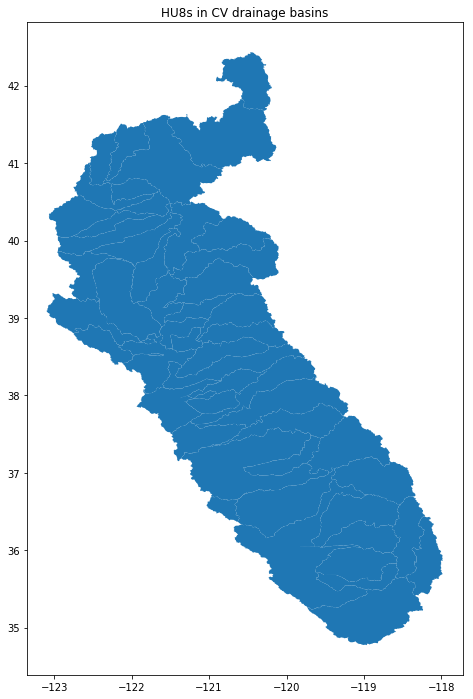

In [9]:
plt.figure()
rdf.plot(figsize = (15, 12))
plt.title("HU8s in CV drainage basins")

In [150]:
# rdf.to_file("../nhd/cv_hu10.shp")

In [10]:
# Sac river huc8s are: 
sac_hu8s = ["18040003", "18020163", "18040012", "18020162"]

In [11]:
sac_delta = rdf[rdf['HUC8'].isin(sac_hu8s)]

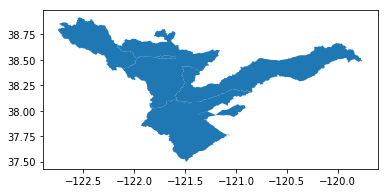

In [12]:
sac_delta.plot()

In [13]:
def get_stremflow(huc8):
    
    '''
    call climata API supplying huc8 argument to get each gaging station within each basin 
    '''
    
    data =  DailyValueIO (
            start_date="1980-01-01", 
            end_date="2018-01-01",
            basin=huc8,
            parameter="00060",
            )
    
    qs = []
    ds = []
    lats = []
    lons = []
    ids = []

    for series in data:
        values = []
        dates = []
        lats.append(series.latitude)
        lons.append(series.longitude)
        ids.append(series.site_code)

        for row in series.data:
            values.append(row.value)
            dates.append(row.date)

        qs.append(values)
        ds.append(dates)
    
    geometry = [Point(xy) for xy in zip(lons, lats)]
    df = pd.DataFrame(geometry)
    crs = {'init': 'epsg:4326'}
    gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return gdf, qs, ds, ids

In [14]:
gdfs = []
qs = []
ds = []
ids = []

for i in sac_delta['HUC8']:
    gdf, q, d, i = get_stremflow(i)
    gdfs.append(gdf)
    qs.append(q)
    ds.append(d)
    ids.append(i)


In [15]:
gdf_f = [item for sublist in gdfs for item in sublist]
q_f = np.array([item for sublist in qs for item in sublist])
d_f = np.array([item for sublist in ds for item in sublist])
ids_f = [item for sublist in ids for item in sublist]

In [16]:
pgdf = gp.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

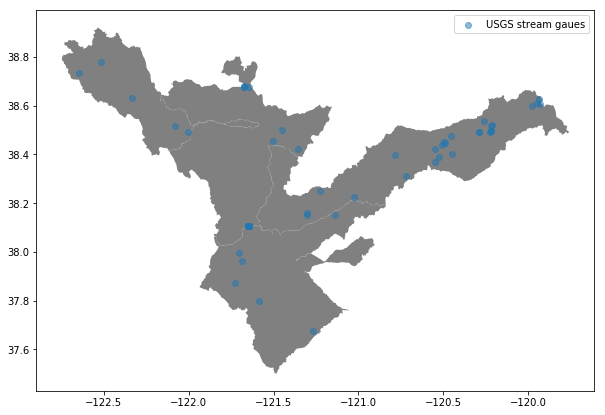

In [17]:
fig, ax = plt.subplots(1, figsize=(10,7))
base = sac_delta.plot(ax=ax, color='gray',label = "HUC8s")
pgdf.plot(ax=base, marker="o", alpha=0.5, label = "USGS stream gaues")
plt.legend()
plt.show()

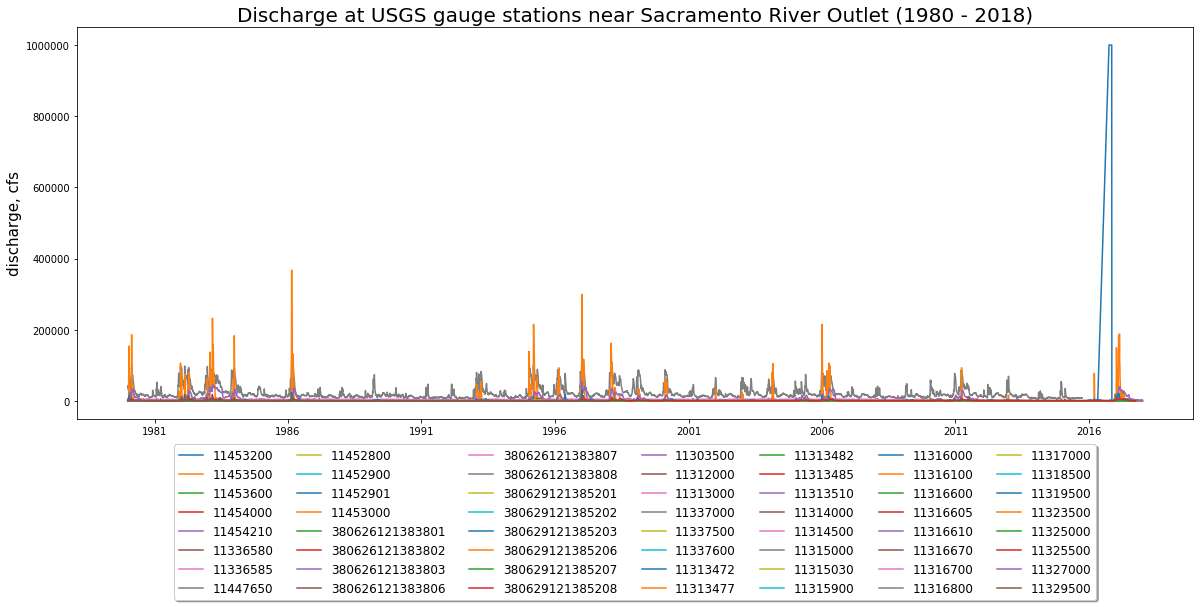

In [18]:
fig = plt.figure(figsize = (20,8))
ax = plt.subplot(111)

for i, x in enumerate(q_f):
    line = ax.plot(d_f[i],np.abs(q_f[i]), label = ids_f[i])
    
# ax.legend(loc='upper left',ncol=7, fancybox=True, prop={'size': 12})

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=7, prop = {"size":12})


plt.xlabel("year", size = 15)
plt.ylabel("discharge, cfs", size = 15)
plt.title("Discharge at USGS gauge stations near Sacramento River Outlet (1980 - 2018)", size = 20)
plt.show()

In [19]:
# Extract biggest discharge from timeseries and plot

idx = 0
currentmean = 0
for i, x in enumerate(q_f): 
    mean = np.mean(x)
    if mean > currentmean:
        currentmean = mean
        idx = i

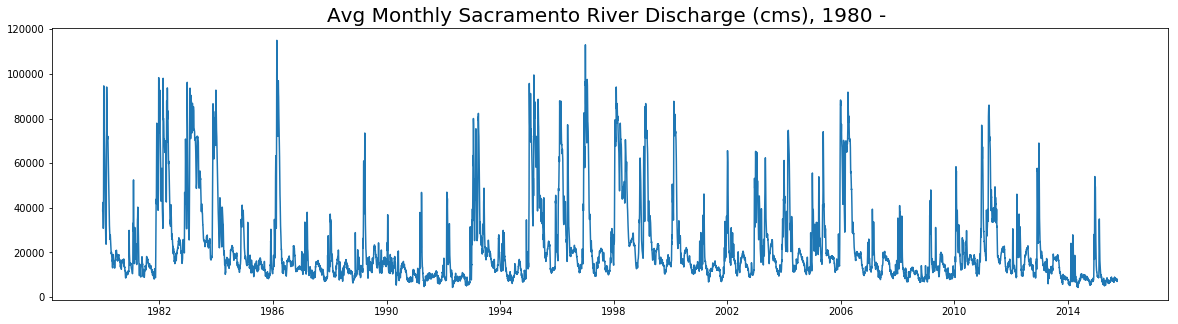

In [21]:
plt.figure(figsize = (20,5))
plt.plot(d_f[idx], q_f[idx])
plt.title("Avg Monthly Sacramento River Discharge (cms), 1980 - ", size = 20)
plt.show()

In [22]:
# convert cfs to cms and save
sac_q = np.array([x* 0.0283168 for x in q_f[idx]])
Qs = pd.DataFrame(sac_q , index = d_f[idx])
Qs.columns = ['discharge_cms']
# Qs.to_csv("../data/Qs.csv")

In [23]:
# Extract mean discharges from timeseries

In [24]:
means = []
for i, x in enumerate(q_f): 
    means.append(np.mean(x))
    
pgdf['mean'] = means

In [25]:
# Get the NHD areas (e.g. water bodies) and find intersection with region 

In [26]:
def find_areas(dir, string = "Area"):
    shp_files = [os.path.join(dir,x) for x in os.listdir(dir) if string in x if x.endswith(".shp") if "FC" not in x][0]
    return shp_files

nhd_areas = []
for i in hu4_dirs:
    nhd_areas.append(find_areas(i))
    
dfs = [gp.read_file(x) for x in nhd_areas]

In [27]:
streams = []
for i in dfs:
    streams.append(gp.overlay(sac_delta, i, how = "intersection"))

In [28]:
stf = gp.GeoDataFrame(pd.concat(streams, ignore_index=True))

/Users/aakashahamed/anaconda3/envs/gisanimation/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
No handles with labels found to put in legend.


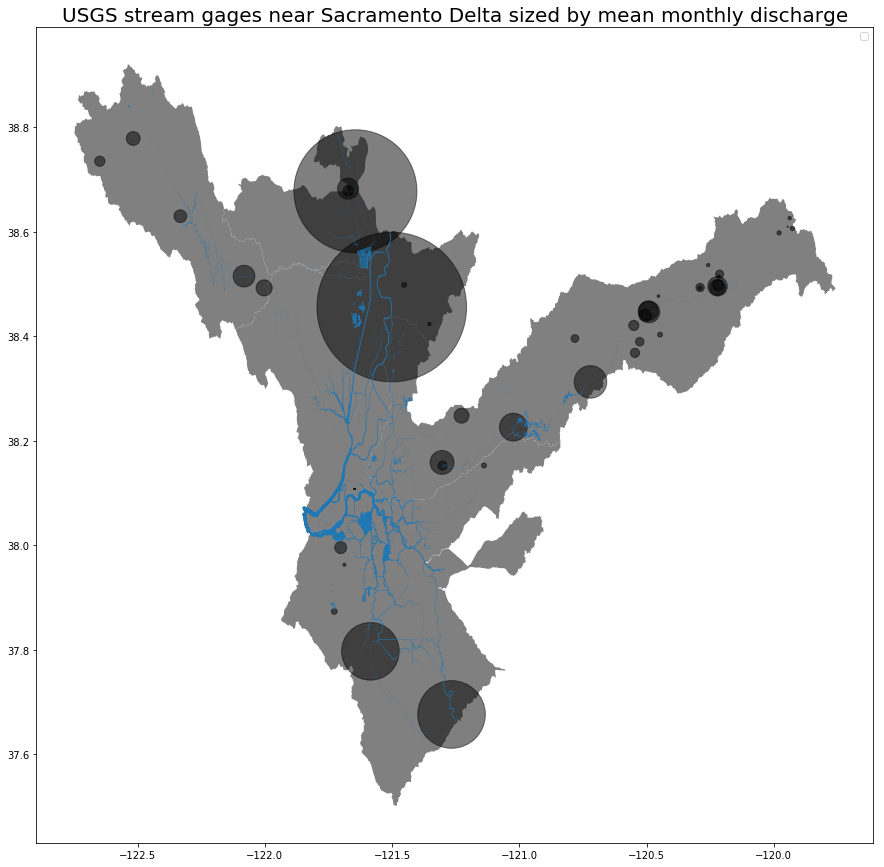

In [29]:
fig, ax = plt.subplots(1, figsize=(15,15))
base = sac_delta.plot(ax=ax, color='gray',label = "HUC8s")
pgdf.plot(ax=base, marker="o", alpha=0.5, c = "black", markersize = pgdf['mean'])
stf.plot(ax = base, label = "streamlines")
plt.legend()

plt.title("USGS stream gages near Sacramento Delta sized by mean monthly discharge", size = 20)
plt.show()